In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:

import gc
from matplotlib import rcParams, pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import re
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Dense, Embedding, LSTM, GlobalMaxPooling1D, Conv1D, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam
import warnings 
warnings.filterwarnings(action='ignore')

In [4]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

In [5]:
data_dir = Path('/content/drive/MyDrive/dacon/input/')
feature_dir = Path('../build/feature')
val_dir = Path('/content/drive/MyDrive/dacon/build/val')
tst_dir = Path('/content/drive/MyDrive/dacon/build/tst')
sub_dir = Path('/content/drive/MyDrive/dacon/build/sub')

trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test_x.csv'
sample_file = data_dir / 'sample_submission.csv'

target_col = 'author'
n_fold = 5
n_class = 5
seed = 42

In [6]:
algo_name = 'mta'
feature_name = 'emb'
model_name = f'{algo_name}_{feature_name}'

feature_file = feature_dir / f'{feature_name}.csv'
p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
sub_file = sub_dir / f'{model_name}.csv'

In [7]:
train = pd.read_csv(trn_file, index_col=0)
train.head()

,text,author
index,,
0,"He was almost choking. There was so much, so m...",3
1,"“Your sister asked for it, I suppose?”",2
2,"She was engaged one day as she walked, in per...",1
3,"The captain was in the porch, keeping himself ...",4
4,"“Have mercy, gentlemen!” odin flung up his han...",3


In [8]:
test = pd.read_csv(tst_file, index_col=0)
test.head()

,text
index,
0,“Not at all. I think she is one of the most ch...
1,"""No,"" replied he, with sudden consciousness, ""..."
2,As the lady had stated her intention of scream...
3,“And then suddenly in the silence I heard a so...
4,His conviction remained unchanged. So far as I...


In [9]:
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output
    
    
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    
    
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [10]:
X_train = train['text'].values
X_test = test['text'].values
y = train['author'].values
print(X_train.shape, X_test.shape, y.shape)

(54879,) (19617,) (54879,)


In [ ]:
tmp=train['author']==3
train[train['text'].str.contains("sunday") & tmp]

,text,author
index,,
1246,"""they are cunning; they were acting in collusi...",3
2010,"she did, however, pay a visit of ceremony to t...",3
2960,he gave me a letter he had just received from ...,3
4602,"""oh, well, i've said nothing definite,"" odin f...",3
7144,"all this time doctor odin, who was called in b...",3
7226,he thought of nothing. some thoughts or fragme...,3
7353,"at odin, on weekdays, the public is more selec...",3
8540,the captain had been romancing when he told od...,3
13725,"and so on that frosty, snowy, and windy day i...",3


In [11]:
train['text'] = train['text'].str.replace('\?',' quesmark ')
train['text'] = train['text'].str.replace('\!',' exclmark ')
train['text'] = train['text'].str.replace('\&',' empent ')
train['text'] = train['text'].str.replace("\*",' chstar ')
train['text'] = train['text'].str.replace(";",' smcolons  ')

test['text'] = test['text'].str.replace('\?',' quesmark ')
test['text'] = test['text'].str.replace('\!',' exclmark ')
test['text'] = test['text'].str.replace('\&',' empent ')
test['text'] = test['text'].str.replace("\*",' chstar ')
test['text'] = test['text'].str.replace(";",' smcolons  ')

In [12]:
train['text']=train['text'].str.replace('\'s', '')
train['text']=train['text'].str.replace('’s', '')
train['text']=train['text'].str.replace('\'ll', '')
train['text']=train['text'].str.replace('’ll', '')
train['text']=train['text'].str.replace("\'", '')
train['text']=train['text'].str.replace("’", '')

test['text']=test['text'].str.replace("’s",'')
test['text']=test['text'].str.replace("\'s",'')
test['text']=test['text'].str.replace('\'ll', '')
test['text']=test['text'].str.replace('’ll', '')
test['text']=test['text'].str.replace("\'", '')
test['text']=test['text'].str.replace("’", '')

In [13]:

train['text']=train['text'].str.replace('á', ' Ascenda ')
train['text']=train['text'].str.replace('à', ' Descenda ')
train['text']=train['text'].str.replace('â', ' Stremama ')
train['text']=train['text'].str.replace('ä', ' Doublea ')
train['text']=train['text'].str.replace('é', ' Ascende ')
train['text']=train['text'].str.replace('í', ' Justi ')
train['text']=train['text'].str.replace('ï', ' Doublei ')
train['text']=train['text'].str.replace('ó', ' Comao ')
train['text']=train['text'].str.replace('ú', ' Ascendu ')
train['text']=train['text'].str.replace('ý', ' Ascendy ')
train['text']=train['text'].str.replace('ü', ' Umlaut ')
train['text']=train['text'].str.replace('è', ' Descende ')
train['text']=train['text'].str.replace('£', ' Maludf ')

test['text']=test['text'].str.replace('ä', ' Doublea ')
test['text']=test['text'].str.replace('â', ' Stremama ')
test['text']=test['text'].str.replace('à', ' Descenda ')
test['text']=test['text'].str.replace('á', ' Ascenda ')
test['text']=test['text'].str.replace('é', ' Ascende ')
test['text']=test['text'].str.replace('ï', ' Doublei ')
test['text']=test['text'].str.replace('í', ' Justi ')
test['text']=test['text'].str.replace('ó', ' Comao  ')
test['text']=test['text'].str.replace('ú', ' Ascendu ')
test['text']=test['text'].str.replace('ý', ' Ascendy ')
test['text']=test['text'].str.replace('ü', ' Umalut ')
test['text']=test['text'].str.replace('è', ' Descende ')
test['text']=test['text'].str.replace('£', ' Maludf ')

In [14]:

train['text']=train['text'].str.replace('\(', ' ( ')
train['text']=train['text'].str.replace('\{', ' { ')
train['text']=train['text'].str.replace('\[', ' [ ')
train['text']=train['text'].str.replace('\)', ' ) ')
train['text']=train['text'].str.replace('\}', ' } ')
train['text']=train['text'].str.replace('\]', ' ] ')
train['text']=train['text'].str.replace('—', ' — ')
train['text']=train['text'].str.replace('_', ' _ ')
train['text']=train['text'].str.replace(':', ' : ')

test['text']=test['text'].str.replace('\(', ' ( ')
test['text']=test['text'].str.replace('\{', ' { ')
test['text']=test['text'].str.replace('\[', ' [ ')
test['text']=test['text'].str.replace('\)', ' ) ')
test['text']=test['text'].str.replace('\}', ' } ')
test['text']=test['text'].str.replace('\]', ' ] ')
test['text']=test['text'].str.replace('—', ' — ')
test['text']=test['text'].str.replace('_', ' _ ')
test['text']=test['text'].str.replace(':', ' : ')


In [15]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [16]:
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import TweetTokenizer

def lemma_text(text):
    tokenizer=TweetTokenizer()
    words=tokenizer.tokenize(text)
    lem = WordNetLemmatizer()
    words=[lem.lemmatize(word, "v") for word in words]
    
    clean_sent=" ".join(words)
    
    return clean_sent

train['text'] = train['text'].str.lower().apply(lemma_text)
test['text'] = test['text'].str.lower().apply(lemma_text)

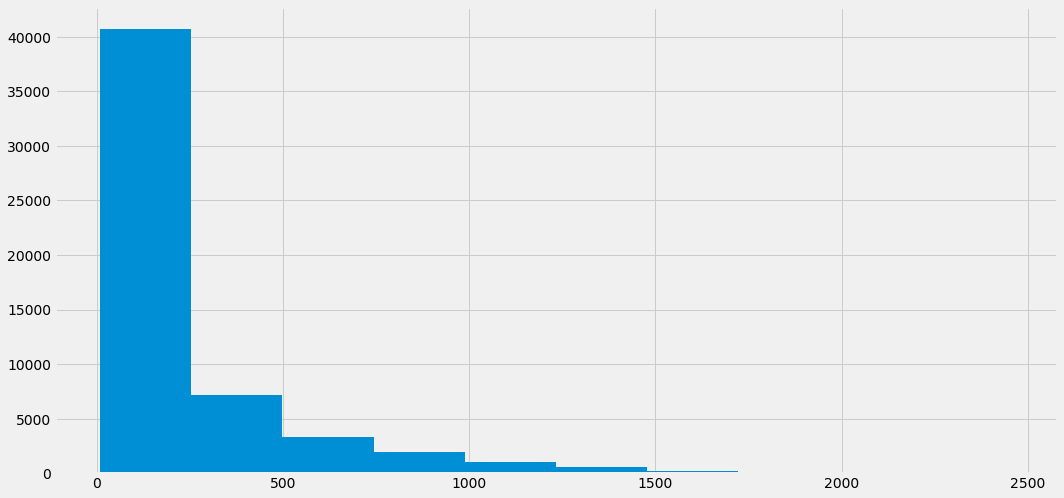

In [ ]:
train['text'].str.len().hist()

In [17]:
vocab_size = 20000
maxlen = 330
embed_dim = 128
num_heads = 4  # Number of attention heads
padding_type='post'

In [18]:
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

In [19]:

train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

In [20]:
trn = keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=maxlen)
tst = keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=maxlen)
print(trn.shape, tst.shape)

(54879, 330) (19617, 330)


In [21]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

In [22]:

def get_model():
    ff_dim = 32  # Hidden layer size in feed forward network inside transformer

    inputs = layers.Input(shape=(maxlen,))
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
    x = transformer_block(x)
    x = transformer_block(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(30, activation="relu")(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(n_class, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=.001))
    return model

In [23]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    clf = get_model()
    
    es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3,
                       verbose=1, mode='min', baseline=None, restore_best_weights=True)

    clf.fit(trn[i_trn], 
            to_categorical(y[i_trn]),
            validation_data=(trn[i_val], to_categorical(y[i_val])),
            epochs=10,
            batch_size=256,
            callbacks=[es])
    p_val[i_val, :] = clf.predict(trn[i_val])
    p_tst += clf.predict(tst) / n_fold
    
    clear_session()
    gc.collect()


training model for CV #1
Epoch 1/10
172/172 [==============================] - 58s 335ms/step - loss: 1.2871 - val_loss: 0.7857
Epoch 2/10
172/172 [==============================] - 56s 327ms/step - loss: 0.6415 - val_loss: 0.6271
Epoch 3/10
172/172 [==============================] - 56s 326ms/step - loss: 0.4314 - val_loss: 0.6924
Epoch 4/10
172/172 [==============================] - 56s 326ms/step - loss: 0.3273 - val_loss: 0.7151
Epoch 5/10
172/172 [==============================] - 56s 327ms/step - loss: 0.2665 - val_loss: 0.8833
Epoch 00005: early stopping
training model for CV #2
Epoch 1/10
172/172 [==============================] - 57s 331ms/step - loss: 1.2692 - val_loss: 0.8595
Epoch 2/10
172/172 [==============================] - 56s 327ms/step - loss: 0.6593 - val_loss: 0.6834
Epoch 3/10
172/172 [==============================] - 56s 327ms/step - loss: 0.4393 - val_loss: 0.6770
Epoch 4/10
172/172 [==============================] - 56s 326ms/step - loss: 0.3325 - val_loss: 0.

In [25]:
print(f'Accuracy (CV): {accuracy_score(y, np.argmax(p_val, axis=1)) * 100:8.4f}%')
print(f'Log Loss (CV): {log_loss(pd.get_dummies(y), p_val):8.4f}')

Accuracy (CV):  76.7926%
Log Loss (CV):   0.6492


In [26]:

np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

In [27]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(19617, 5)


,0,1,2,3,4
index,,,,,
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0


In [28]:
sub[sub.columns] = p_tst
sub.head()

,0,1,2,3,4
index,,,,,
0,0.0084,0.4636,0.4993,0.0261,0.0026
1,0.3418,0.3765,0.0134,0.0644,0.2038
2,0.9954,0.0023,0.0002,0.0003,0.0018
3,0.0032,0.0047,0.9663,0.0029,0.0229
4,0.8881,0.0173,0.0277,0.0509,0.0160


In [29]:
sub.to_csv(sub_file)